# Set up model and hyperparameters

In [1]:
from models.WaveNetVAE.WaveVae import WaveNetVAE
from models.WaveNetVAE.WVData import WVDataset
import torch
import warnings
# warnings.filterwarnings("ignore")

"""
Hyperparameters
"""

batchsize = 10
device='cuda:0'
input_size = (39, 112)
upsamples = [2, 2, 2, 2, 2, 2, 2, 2]
zsize = 32

WaveVAE = WaveNetVAE(input_size,
                     num_hiddens = 768,
                     upsamples = upsamples,
                     zsize = zsize,
                     out_channels = 256,
                     init_type='xavier_u',
                     activation='relu')

WaveVAE = WaveVAE.to(device)


# WaveVAE = torch.nn.DataParallel(WaveVAE, device_ids=[4,5,6,7])


c:\Users\woute\.conda\envs\GeneralAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


WaveNet Receptive Field:  4093


## Load datasets

In [2]:
from models.WaveNetVAE.WVData import WVDataset
from torch.utils.data import DataLoader

VAEDataset = WVDataset(audio_path = "H:/Downloads/LJSpeech-1.1/LJSpeech-1.1/wavs",
                       length = 4096,
                       skip_size = 4096 // 2,
                       sample_rate = 16000,
                       max_files = 2500,
                       train=True)

val_VAEDataset = WVDataset(audio_path = "H:/Downloads/LJSpeech-1.1/LJSpeech-1.1/wavs",
                       length = 4096,
                       skip_size = 4096 // 2,
                       sample_rate = 16000,
                       max_files = 32,
                       train=False)

VAEDataloader = DataLoader(VAEDataset,
                           batch_size = 8,
                           shuffle = True,
                           pin_memory=True,
                           num_workers=4)

val_VAEDataloader = DataLoader(val_VAEDataset,
                           batch_size = 8,
                           shuffle = False,
                           pin_memory=True,
                           num_workers=4)

Loading and preprocessing files to dataset.: 100%|██████████| 13100/13100 [00:01<00:00, 6603.33it/s]


In [3]:
print(len(VAEDataloader))

213


In [7]:
%load_ext autoreload
%autoreload 2

# Test tensor

Trying tensors with sizes:
Snippet size:  torch.Size([1, 4097]) | MFCC size:  torch.Size([1, 39, 24])


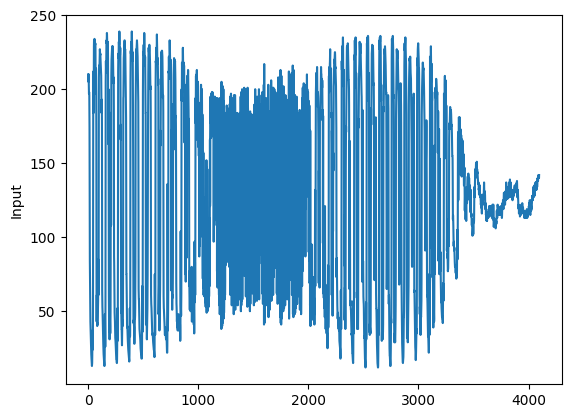

Before downsample:  torch.Size([1, 768, 24])
After downsample:  torch.Size([1, 768, 12])
X size before wavenet:  torch.Size([1, 1, 4096])
Condition before upsampling:  torch.Size([1, 128, 12])
Condition and x after c upsampling:  torch.Size([1, 128, 4096]) torch.Size([1, 1, 4096])


/home/wouter.besse/data/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


Tensors passed through model succesfully torch.Size([1, 4096, 256])
torch.Size([256]) torch.Size([1])
output:  253 target: 142.0 input:  140.0
Reconstruction loss = 5.481293201446533


In [3]:
import torchaudio
import matplotlib.pyplot as plt
import torch
val_VAEDataloader = DataLoader(val_VAEDataset,
                           batch_size = 1,
                           shuffle = True)
# loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.CrossEntropyLoss()

snippet, mfcc = next(iter(val_VAEDataloader))
snippet = snippet.to(device)
mfcc = mfcc.to(device)

print("Trying tensors with sizes:")
print("Snippet size: ", snippet.size(), "| MFCC size: ", mfcc.size())

plt.plot(torch.squeeze(snippet[0]).cpu().numpy())
plt.ylabel('Input')
plt.show()

output, _, _ = WaveVAE(snippet[...,:4096].unsqueeze(1), mfcc, True, True)
output = output.transpose(2,1)
print("Tensors passed through model succesfully", output.size())

# reconstruction_loss = torch.mean(loss_fn(torch.squeeze(output), torch.squeeze(target)[:, 1:])[-1], 0)

print(output[0, -1].size(), snippet[..., -1].contiguous().view(-1).size())
print('output: ', torch.argmax(output[0, -1].squeeze()).item(), 'target:', snippet[0, -1].squeeze().item(), 'input: ', snippet[0, -2].squeeze().item())

reconstruction_loss = loss_fn(output[0, -1].cpu(), snippet[0, -1].type(torch.LongTensor))
print("Reconstruction loss =", reconstruction_loss.item())




# Start training

In [3]:
from models.WaveNetVAE.train import train
# from torch.utils.tensorboard import SummaryWriter
import wandb
import warnings
warnings.filterwarnings("ignore")
torch.cuda.empty_cache()

wandb.init(
    # set the wandb project where this run will be logged
    project="WavenetVAE",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.00001,
    "architecture": "WavenetVAE",
    "dataset": "LJSpeech",
    "epochs": 1,
    "max_files_train": 2500,
    "max_files_eval": 16,
    "xavier_init": True,
    "divide skips & res": False,
    "res channels": 256,
    "init": 'xavier_u',
    'activation': 'relu',
    }
)



train(WaveVAE, VAEDataloader, val_VAEDataloader,
      learning_rate = 0.00001,
      epoch_amount = 1,
      logs_per_epoch = len(VAEDataloader)//1000,
      kl_anneal = 0.05,
      max_kl = 1.0,
      device = device,
     export_path = './exports/')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wouterbesse. Use `wandb login --relogin` to force relogin


swag


Training. Epoch: 0. Loss for step 1: n.v.t.:   0%|          | 0/15517 [00:02<?, ?it/s]


RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED

In [3]:
torch.save(WaveVAE.state_dict(), './modeltest')

# Generate Audio

In [35]:
from models.WaveNetVAE.WaveVae import WaveNetVAE
from models.WaveNetVAE.WVData import WVDataset
import torch
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

"""
Hyperparameters
"""

learning_rate = 0.000001
batchsize = 4
device=['cuda:5','cuda:6']
input_size = (39, 112)
upsamples = [2, 2, 2, 2, 2, 2, 2, 2]
zsize = 32

WaveVAE = WaveNetVAE(input_size,
                     num_hiddens = 768,
                     upsamples = upsamples,
                     zsize = zsize,
                    out_channels = 256)

# WaveVAE.to(device)

WaveVAE.load_state_dict(torch.load('./exports_leaky/2023-05-260'))

changed again22
changed!
WaveNet Receptive Field:  4093


<All keys matched successfully>

In [36]:
val_VAEDataset = WVDataset(audio_path = "./dataset/LJSpeech-1.1/wavs",
                       length = 4096,
                       skip_size = 1,
                       sample_rate = 16000,
                       max_files = 2,
                       is_generating=True)

val_VAEDataloader = DataLoader(val_VAEDataset,
                           batch_size = 1,
                           shuffle = False)
# with torch.no_grad():
    # generated_audio = WaveVAE.inference(val_VAEDataloader, size = 4096, device = device)

Loading and preprocessing files to dataset.:   0%|          | 0/2 [00:00<?, ?it/s]

./dataset/LJSpeech-1.1/wavs/LJ018-0238.wav


  0%|          | 0/32000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [32]:
import IPython
import torchaudio
print(generated_audio.size())
transform = torchaudio.transforms.MuLawDecoding(quantization_channels=256)
generated_audio_proc = generated_audio
decoded = transform(generated_audio_proc)
IPython.display.display(IPython.display.Audio(decoded.squeeze().detach().cpu().numpy(), rate = 16000))

torch.Size([1, 36096])


torch.Size([1, 4096])


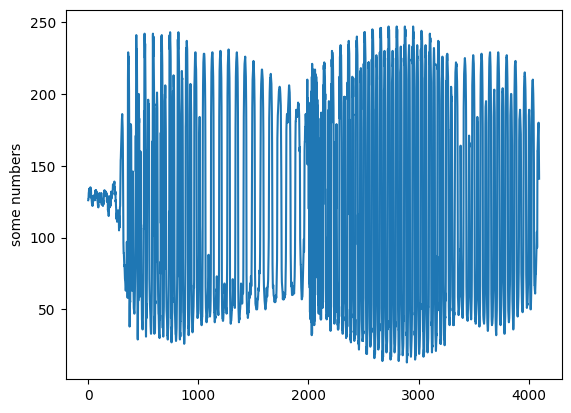

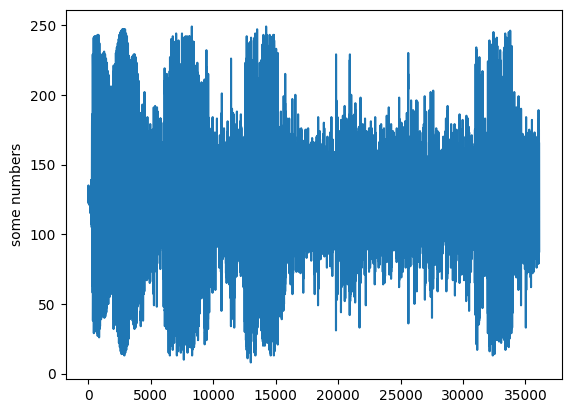

In [33]:
onehot, mfcc = next(iter(val_VAEDataloader))

import matplotlib.pyplot as plt
print(onehot[:, -4096:].size())
plt.plot(torch.squeeze(onehot[:, -4096:]).numpy())
plt.ylabel('some numbers')
plt.show()

plt.plot(torch.squeeze(generated_audio_proc.cpu()).numpy())
plt.ylabel('some numbers')
plt.show()